In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# BiLstm+ bert

In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers sentencepiece scikit-learn matplotlib seaborn tqdm


Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached https://download.pytorch.org/whl/triton-3.3.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━

KeyboardInterrupt: 

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Val F1 = 0.8623, Acc = 0.8618, Loss = 0.3511
Epoch 2: Val F1 = 0.8855, Acc = 0.8840, Loss = 0.3006
Epoch 3: Val F1 = 0.8869, Acc = 0.8880, Loss = 0.2864
Epoch 4: Val F1 = 0.8942, Acc = 0.8907, Loss = 0.2838
Epoch 5: Val F1 = 0.8961, Acc = 0.8951, Loss = 0.2724
Epoch 6: Val F1 = 0.8891, Acc = 0.8920, Loss = 0.2734

Test Accuracy: 0.893
Test F1 Score: 0.892375779521223

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.91      0.89      2470
    Positive       0.91      0.88      0.89      2530

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



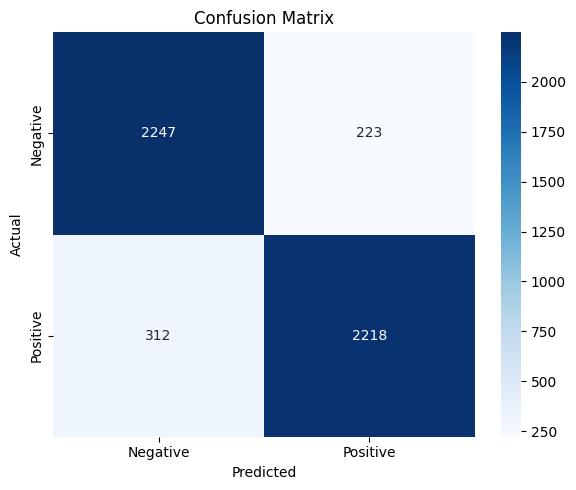

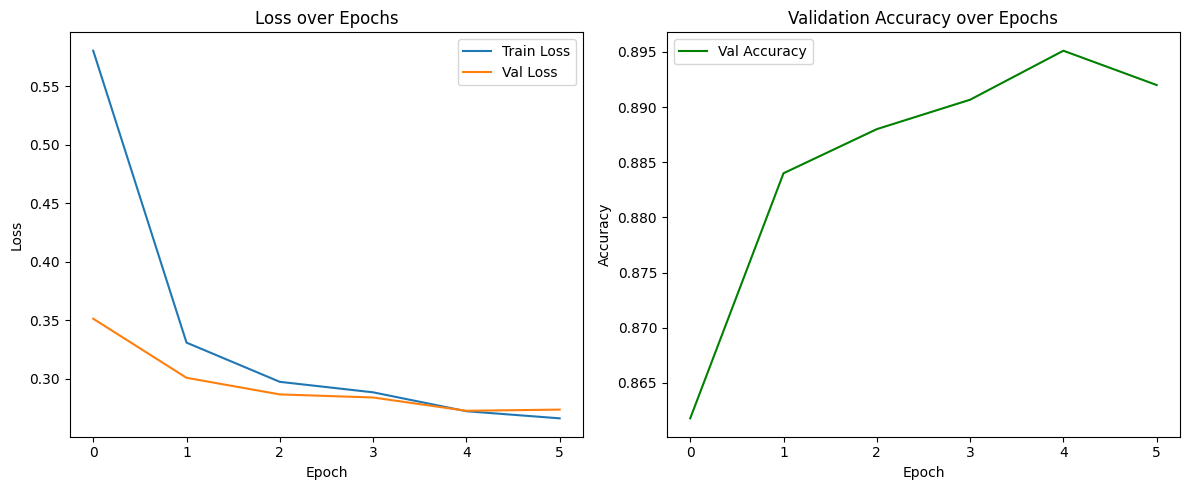

In [ ]:
# Install required packages (if running in Colab or fresh environment)
# !pip install torch torchvision torchaudio transformers sentencepiece scikit-learn matplotlib seaborn tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load & preprocess
def load_data(train_size=15000, test_size=5000):
    train_df = pd.read_csv('/content/drive/MyDrive/datasets/train.csv', header=None, names=['polarity', 'title', 'text'])
    test_df = pd.read_csv('/content/drive/MyDrive/datasets/test.csv', header=None, names=['polarity', 'title', 'text'])

    for df in [train_df, test_df]:
        df['title'] = df['title'].fillna("")
        df['text'] = df['text'].fillna("")
        df['combined_text'] = (df['title'] + " " + df['text']).str.strip().str.replace(r'\s+', ' ', regex=True)
        df['labels'] = df['polarity'] - 1

    train_df = train_df.sample(n=min(train_size, len(train_df)), random_state=42).reset_index(drop=True)
    test_df = test_df.sample(n=min(test_size, len(test_df)), random_state=42).reset_index(drop=True)
    return train_df, test_df

train_df, test_df = load_data()
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['combined_text'], train_df['labels'],
    test_size=0.15, random_state=42, stratify=train_df['labels']
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

class BERTDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors='pt')
        self.labels = torch.tensor(labels.values)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BERTDataset(train_texts, train_labels)
val_dataset = BERTDataset(val_texts, val_labels)
test_dataset = BERTDataset(test_df['combined_text'], test_df['labels'])

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class BERTBiLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.5, output_dim=2):
        super(BERTBiLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Freeze all layers initially
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last two encoder layers
        for name, param in self.bert.named_parameters():
            if 'encoder.layer.10' in name or 'encoder.layer.11' in name:
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_output.last_hidden_state
        lstm_out, _ = self.lstm(x)
        avg_pool = torch.mean(lstm_out, dim=1)
        x = self.dropout(avg_pool)
        return self.fc(x)

model = BERTBiLSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Training / Evaluation
EPOCHS = 6
early_stopping_patience = 2
train_loss_values, val_loss_values, val_acc_values = [], [], []

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return total_loss / len(loader), acc, precision, recall, f1, y_true, y_pred

def train_model(model):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch in train_loader:
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        train_loss_values.append(total_loss / len(train_loader))
        val_loss, val_acc, val_prec, val_recall, val_f1, _, _ = evaluate(model, val_loader)
        val_loss_values.append(val_loss)
        val_acc_values.append(val_acc)
        print(f"Epoch {epoch+1}: Val F1 = {val_f1:.4f}, Acc = {val_acc:.4f}, Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_bilstm_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping.")
                break

train_model(model)
model.load_state_dict(torch.load('best_bilstm_model.pt'))

# Final Evaluation
test_loss, test_acc, test_prec, test_recall, test_f1, y_true, y_pred = evaluate(model, test_loader)
print("\nTest Accuracy:", test_acc)
print("Test F1 Score:", test_f1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot Loss & Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_values, label='Val Accuracy', color='green')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


#Bert model

In [ ]:
!pip install torchtext --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 874.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 973.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 635.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
!pip install torch==2.0.1 torchtext==0.15.2 --upgrade --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 449.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 955.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Train Acc: 0.5173, Val Acc: 0.6833, Val Loss: 0.6394
New best model saved with validation loss: 0.6394
Epoch 2: Train Acc: 0.7506, Val Acc: 0.9137, Val Loss: 0.2470
New best model saved with validation loss: 0.2470
Epoch 3: Train Acc: 0.9081, Val Acc: 0.9317, Val Loss: 0.1943
New best model saved with validation loss: 0.1943
Epoch 4: Train Acc: 0.9258, Val Acc: 0.9373, Val Loss: 0.1828
New best model saved with validation loss: 0.1828
Epoch 5: Train Acc: 0.9340, Val Acc: 0.9393, Val Loss: 0.1750
New best model saved with validation loss: 0.1750
Epoch 6: Train Acc: 0.9363, Val Acc: 0.9373, Val Loss: 0.1737
New best model saved with validation loss: 0.1737
Epoch 7: Train Acc: 0.9386, Val Acc: 0.9403, Val Loss: 0.1720
New best model saved with validation loss: 0.1720
Epoch 8: Train Acc: 0.9429, Val Acc: 0.9417, Val Loss: 0.1720
New best model saved with validation loss: 0.1720
Epoch 9: Train Acc: 0.9434, Val Acc: 0.9420, Val Loss: 0.1719
New best model saved with validation loss:

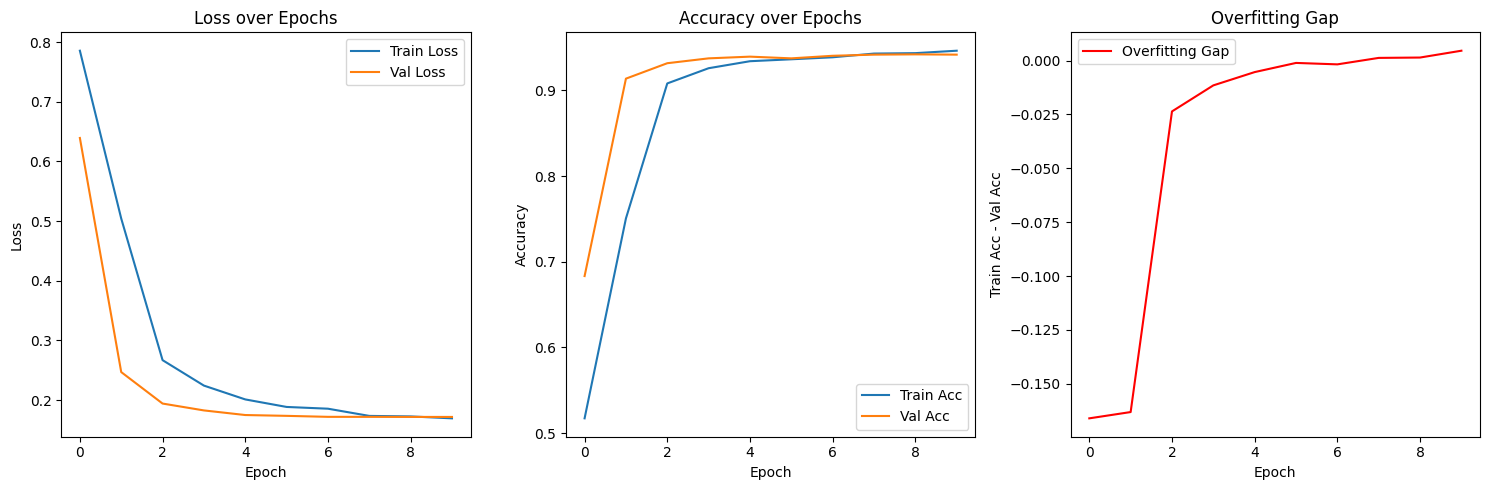

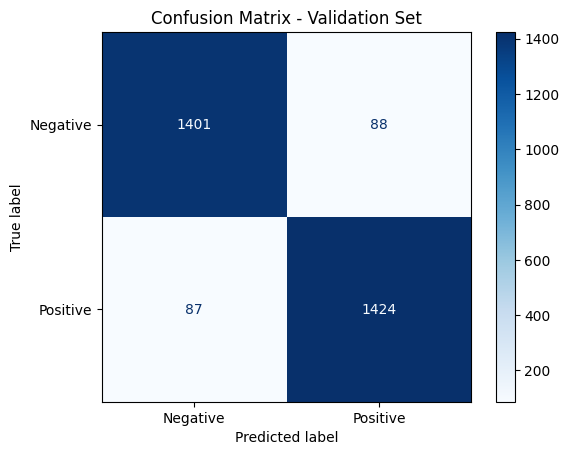


Classification Report (Validation Set):

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      1489
    Positive       0.94      0.94      0.94      1511

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000


Validation Metrics:
Accuracy: 0.9417
Precision: 0.9417
Recall: 0.9417
F1-Score: 0.9417


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, get_scheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os


def load_data(train_size=15000, test_size=5000):
    train_df = pd.read_csv('/content/drive/MyDrive/datasets/train.csv', header=None, names=['polarity', 'title', 'text'])
    test_df = pd.read_csv('/content/drive/MyDrive/datasets/test.csv', header=None, names=['polarity', 'title', 'text'])

    for df in [train_df, test_df]:
        df['title'] = df['title'].fillna("")
        df['text'] = df['text'].fillna("")
        df['combined_text'] = (df['title'] + " " + df['text']).str.strip().str.replace(r'\s+', ' ', regex=True)
        df['labels'] = df['polarity'] - 1

    train_df = train_df.sample(n=min(train_size, len(train_df)), random_state=42).reset_index(drop=True)
    test_df = test_df.sample(n=min(test_size, len(test_df)), random_state=42).reset_index(drop=True)

    return train_df, test_df


train_df, test_df = load_data()
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['combined_text'], train_df['labels'], test_size=0.2, random_state=42, stratify=train_df['labels']
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels, max_len=256):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors='pt'
    )
    return encodings, torch.tensor(labels.tolist())

train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class BERTClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.6):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        for i in range(8):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False

        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate * 0.7)
        self.dropout3 = nn.Dropout(dropout_rate * 0.3)

        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output

        x = self.dropout1(pooled_output)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout2(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout3(x)

        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(dropout_rate=0.6).to(device)

optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.05)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

best_val_loss = float('inf')
patience = 2
patience_counter = 0
best_model_path = 'best_model.pth'

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch, labels in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch, labels in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load(best_model_path))
print("Loaded best model for evaluation")

# Plot training progress
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(train_accs) - np.array(val_accs), label='Overfitting Gap', color='red')
plt.title("Overfitting Gap")
plt.xlabel("Epoch")
plt.ylabel("Train Acc - Val Acc")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on validation set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch, labels in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Final Report
print("\nClassification Report (Validation Set):\n")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))
print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
